## 多信号策略逻辑：

1. CCI指标（30分钟信号）
2. RSI指标（30分钟信号）
3. MA指标（60分钟）
4. 固定比率吊灯止损（分钟）

In [1]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

class MultiSignalStrategy(CtaTemplate):
    className = 'MultiSignalStrategy'
    author = 'ChannelCMT'

    amWindow = 20
    # 策略参数
    smaPeriod = 20; lmaPeriod = 55
    cciPeriod = 10; cciThrehold = 10
    rsiPeriod = 10; rsiEntry = 12
    trailingPct = 0.04
    lot = 1

    
    # 策略变量
    transactionPrice = {} # 记录成交价格
    intraTradeHighDict = {}; intraTradeLowDict = {}
    RSI = {}; CCI = {}; MA = {}
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'amWindow',
                 'rsiPeriod', 'rsiEntry',
                 'cciPeriod', 'cciThreshold',
                 'smaPeriod', 'lmaPeriod',
                 'trailingPct']  
    
    # 变量列表，保存了变量的名称
    varList = ['transactionPrice'
               'intraTradeHighDict', 'intraTradeLowDict'
               'RSI', 'CCI', 'MA'] 
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList}
        self.intraTradeHighDict = {s:0 for s in self.symbolList}
        self.intraTradeLowDict = {s:999999 for s in self.symbolList}
        self.RSI = {s:0 for s in self.symbolList}
        self.CCI = {s:0 for s in self.symbolList}
        self.MA = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        symbol = bar.vtSymbol
        
        # 洗价器（止盈止损）
        if self.posDict[symbol+'_LONG'] == 0 and self.posDict[symbol+'_SHORT'] == 0:
            self.intraTradeHighDict[symbol] = 0
            self.intraTradeLowDict[symbol] = 999999

        # 持有多头仓位
        elif self.posDict[symbol+'_LONG'] >0:
            self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
            self.longStop = self.intraTradeHighDict[symbol]*(1-self.trailingPct)
            if bar.close<=self.longStop:
                self.cancelAll()
                self.sell(symbol, bar.close*0.9, self.posDict[symbol+'_LONG'])

#         # 持有空头仓位
        elif self.posDict[symbol+'_SHORT'] >0:
            self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
            self.shortStop = self.intraTradeLowDict[symbol]*(1+self.trailingPct)
            if bar.close>=self.shortStop:
                self.cancelAll()
                self.cover(symbol, bar.close*1.1, self.posDict[symbol+'_SHORT'])
        self.putEvent()

    def on30MinBar(self, bar):
        symbol = bar.vtSymbol
        am30 = self.getArrayManager(symbol, "30m")
        
        if not am30.inited:
            return
        
        cci = ta.CCI(am30.high, am30.low, am30.close, self.cciPeriod)
        rsi = ta.RSI(am30.close, self.rsiPeriod)
        rsiLong = 50 + self.rsiEntry
        rsiShort = 50 - self.rsiEntry
        
        if cci[-1]>self.cciThrehold:
            self.CCI[symbol] = 1
        elif cci[-1]<-self.cciThrehold:
            self.CCI[symbol] = -1
        else:
            self.CCI[symbol] = 0
        
        if rsi[-1]>=rsiLong:
            self.RSI[symbol] = 1
        elif rsi[-1]<=rsiShort:
            self.RSI[symbol] = -1
        else:
            self.RSI[symbol] = 0
        
        # 发出状态更新事件
        self.putEvent()

    def on60MinBar(self, bar):
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m")
        
        if not am60.inited:
            return
        
        SMA = ta.MA(am60.close, self.smaPeriod)
        LMA = ta.MA(am60.close, self.lmaPeriod)
        
        if SMA[-1]>LMA[-1]:
            self.MA[symbol] = 1
        elif SMA[-1]<LMA[-1]:
            self.MA[symbol] = -1
        else:
            self.MA[symbol] = 0
        
        Signal = self.MA[symbol]+self.CCI[symbol]+self.RSI[symbol]

        if (Signal>=2) and (self.posDict[symbol+'_LONG']==0):
            if self.posDict[symbol+'_SHORT']==0:
                self.buy(symbol,bar.close*1.02, self.lot)
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll()
                self.cover(symbol,bar.close*1.1, self.posDict[symbol+'_SHORT'])
                self.buy(symbol,bar.close*1.1, self.lot)
            
        elif (Signal<=-2) and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
                self.short(symbol,bar.close*0.9, self.lot)
            elif self.posDict[symbol+'_LONG']>0:
                self.cancelAll()
                self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])
                self.short(symbol,bar.close*0.98, self.lot)
        self.putEvent()

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
#             print(trade.tradeTime, self.posDict)

    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [2]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiSignalStrategy.on60MinBar at 0x11cf7ed90>, <__main__.MultiSignalStrategy object at 0x11105f160>)
[DEBUG] 注册品种BTCUSDT:binance上的on_30Min_bar函数functools.partial(<function MultiSignalStrategy.on30MinBar at 0x11cf7ec80>, <__main__.MultiSignalStrategy object at 0x11105f160>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiSignalStrategy.onBar at 0x11cf7ed08>, <__main__.MultiSignalStrategy object at 0x11105f160>)
2018-12-04 22:10:45.279159	开始回测
2018-12-04 22:10:45.279308	策略初始化
2018-12-04 22:10:45.281605	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-04 22:10:46.507919	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-04 22:10:46.514794	载入完成，数据量：12000
2018-12-04 22:10:46.515147	策略初始化完成
2018-12-04 22:10:46.515249	策略启动完成
2018-12-04 22:10:46.515367	开始回放回测数据,回测范围:[20180901 12:00,20181125 12:00)
2018-12-04 22:10:46.539333	载入历史数据。

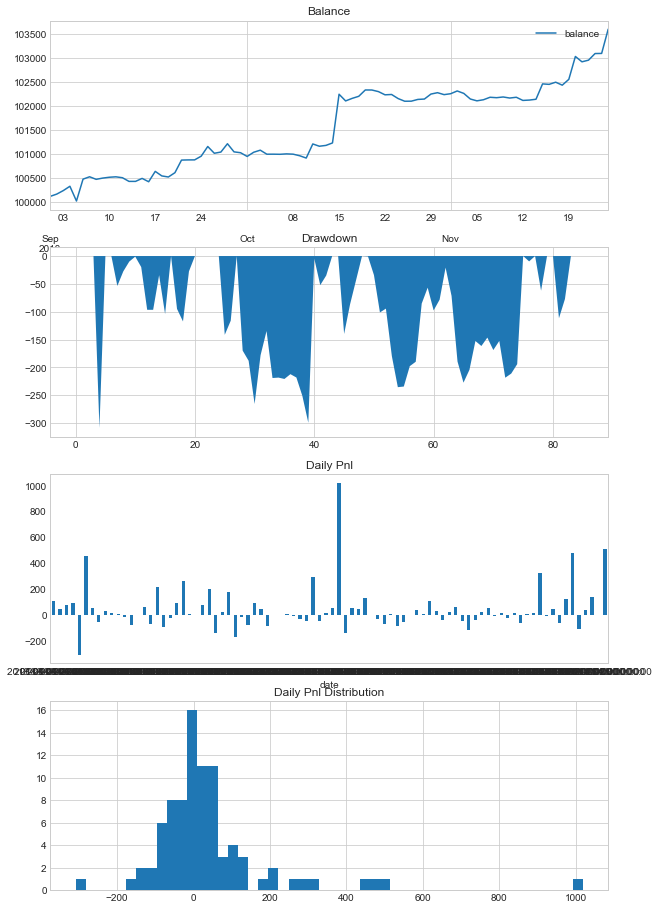

2018-12-04 22:11:39.143431	计算回测结果
2018-12-04 22:11:39.160494	------------------------------
2018-12-04 22:11:39.160913	第一笔交易：	2018-09-05 17:59:00
2018-12-04 22:11:39.161017	最后一笔交易：	2018-11-25 11:58:00
2018-12-04 22:11:39.161114	总交易次数：	59
2018-12-04 22:11:39.161198	总盈亏：	3,605.27
2018-12-04 22:11:39.161271	最大回撤: 	-361.43
2018-12-04 22:11:39.161579	平均每笔盈利：	61.11
2018-12-04 22:11:39.161656	平均每笔滑点：	0.0
2018-12-04 22:11:39.161809	平均每笔佣金：	6.08
2018-12-04 22:11:39.161987	胜率		45.76%
2018-12-04 22:11:39.164752	盈利交易平均值	198.05
2018-12-04 22:11:39.164953	亏损交易平均值	-54.44
2018-12-04 22:11:39.165088	盈亏比：	3.64


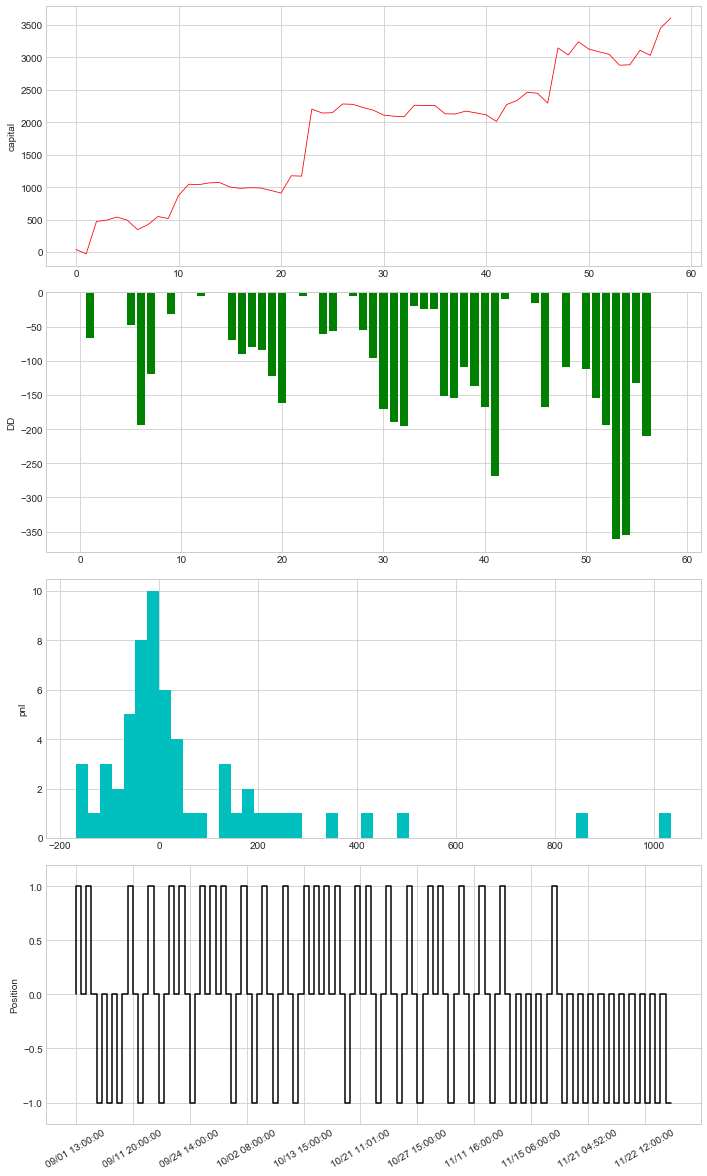

2018-12-04 22:11:41.414280	计算按日统计结果


(                netPnl  slippage  commission  turnover  tradeCount  \
 date                                                                 
 2018-09-01  108.980990     0.002    3.527010   7054.02           1   
 2018-09-02   47.710000     0.000    0.000000      0.00           0   
 2018-09-03   73.780000     0.000    0.000000      0.00           0   
 2018-09-04   89.870000     0.000    0.000000      0.00           0   
 2018-09-05 -308.746760     0.008   14.128760  28257.52           4   
 2018-09-06  457.813530     0.002    3.264470   6528.94           1   
 2018-09-07   49.553770     0.002    3.214230   6428.46           1   
 2018-09-08  -53.710000     0.000    0.000000      0.00           0   
 2018-09-09   26.187995     0.002    3.200005   6400.01           1   
 2018-09-10   17.574105     0.006    9.509895  19019.79           3   
 2018-09-11    8.885230     0.004    6.280770  12561.54           2   
 2018-09-12  -18.760000     0.000    0.000000      0.00           0   
 2018-

In [3]:
parameterDict = {'symbolList':['BTCUSDT:binance']}
runBacktesting(MultiSignalStrategy, parameterDict, '20180901 12:00', '20181125 12:00', 0.002, 5/10000)

In [4]:
# 显示逐日回测结果
engine.showDailyResult()

NameError: name 'engine' is not defined